In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import log_loss, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns


from itertools import combinations
import random

from PIL import Image

import warnings
warnings.filterwarnings("ignore")




In [ ]:
base_path = "/kaggle/input/final-deepmind-comp-dataset/final_deepmind_comp_dataset/zindi_data/"
additional_path = "/kaggle/input/final-deepmind-comp-dataset/final_deepmind_comp_dataset/image_classifier_results/"
train = pd.read_csv(base_path + "Train.csv")
test = pd.read_csv(base_path + "Test.csv")
train_with_cv_results = pd.read_csv(additional_path + "train_with_cv_results.csv")[['location_id', 'flood_probability']]
test_with_cv_results = pd.read_csv(additional_path + "test_with_cv_results.csv")[['location_id', 'flood_probability',]]
submission = pd.read_csv(base_path + "SampleSubmission.csv")
images = np.load(base_path + "composite_images.npz")
display(train.head(), train.shape, train_with_cv_results.head(), train_with_cv_results.shape, test.head(), test.shape)


,event_id,precipitation,label
0,id_spictby0jfsb_X_0,0.000000,0
1,id_spictby0jfsb_X_1,0.095438,0
2,id_spictby0jfsb_X_2,1.949560,0
3,id_spictby0jfsb_X_3,3.232160,0
4,id_spictby0jfsb_X_4,0.000000,0


(492020, 3)

,location_id,flood_probability
0,id_05v6zjuaf300,0.997973
1,id_06zma02zeea7,0.006545
2,id_08w2po0cz63y,0.006836
3,id_092vetuky9ku,0.034579
4,id_0987b1h04r48,0.999697


(674, 2)

,event_id,precipitation
0,id_j7b6sokflo4k_X_0,0.00000
1,id_j7b6sokflo4k_X_1,3.01864
2,id_j7b6sokflo4k_X_2,0.00000
3,id_j7b6sokflo4k_X_3,16.61520
4,id_j7b6sokflo4k_X_4,2.56706


(163520, 2)

In [ ]:
# List all keys in the .npz file
print("Keys in the .npz file:", images.files)

# Access the first image array (adjust the key name as needed)
key_name = images.files[0]  # Replace with the correct key if needed
image_array = images[key_name]

# Print the shape of the image
print("Shape of the image array:", image_array.shape)

# Extract the number of bands (assumes shape is (height, width, bands))
if image_array.ndim == 3:
    num_bands = image_array.shape[2]
    print("Number of bands in the image:", num_bands)
else:
    print("The image array does not have multiple bands (2D array).")

Keys in the .npz file: ['id_rhg5w8vmv3ny', 'id_rua8ey2jczl0', 'id_073l04ir88sn', 'id_wmkfqw7iwjmu', 'id_heri806er7xw', 'id_irft382nqvp0', 'id_ja1tvofxh403', 'id_2uyqsuz0anf7', 'id_h4hkhfp6ilg3', 'id_49o19mx5bbhc', 'id_g1tlrzptebsd', 'id_qg3xwgh1lfdd', 'id_595gz650j6u8', 'id_66akbt5q6bks', 'id_nmyx181qwsk3', 'id_stkvzvg77on0', 'id_1kctttnnhvjx', 'id_xk3049ov4j0u', 'id_f5e7zme7gqnb', 'id_61fh1d5zbsdr', 'id_sfedhmsqwbu4', 'id_oud1p540x3pe', 'id_iyay05bn5zwk', 'id_57cnhhuvhsxb', 'id_fi3md8cxzmp3', 'id_zgckftx7lo64', 'id_3f33h3wta3on', 'id_j7b6sokflo4k', 'id_m5wawccfyrn7', 'id_sww2v8tfqkrn', 'id_g0ydhtmd4ogx', 'id_aaf6d4a9hwq6', 'id_gt66wk2twhn3', 'id_8n80txb7wwsb', 'id_t437fhetcaf4', 'id_flkg8jcrzmrp', 'id_u5e7kr73e7k1', 'id_5i6fbm6h7y4e', 'id_pk95ni8fdeaq', 'id_vdzsn80c9e7r', 'id_f8pw6e0tebe5', 'id_j7moaw4bpjkp', 'id_omhl52u0te84', 'id_3ntxqfjssoln', 'id_5sq85iwd29vq', 'id_4e2iscrtbn5p', 'id_59uqistnu2di', 'id_0nu2nus290am', 'id_ukly29b2hds3', 'id_qgcksf3v8071', 'id_n07bvjlz6ekg', 'id_e2s

In [ ]:
train[train['label']== 1].describe()

,precipitation,label
count,318.000000,318.0
mean,13.801880,1.0
std,18.892779,0.0
min,0.000000,1.0
25%,0.000000,1.0
50%,4.998505,1.0
75%,20.140200,1.0
max,88.336000,1.0


In [ ]:
train[train['label']== 0].describe()

,precipitation,label
count,491702.000000,491702.0
mean,1.557776,0.0
std,5.461300,0.0
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,0.0
75%,0.000000,0.0
max,277.346000,0.0


In [ ]:
def get_location(value):
  return value.split("_")[0] + '_' + value.split("_")[1]

def get_event_id(value):
  return value.split("_")[3]
for df in [train, test]:

  df['location_id'] = df['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
  df['event_idx'] = df.groupby('location_id', sort=False).ngroup()

  df['event_t'] = df.groupby('location_id').cumcount()

print(len(set(train['location_id'])), len(set(test['location_id'])))
print(len(set(train['location_id']).intersection(set(test['location_id']))))
print(len(images))
display(train.head(), test.head())

674 224
0
898


,event_id,precipitation,label,location_id,event_idx,event_t
0,id_spictby0jfsb_X_0,0.000000,0,id_spictby0jfsb,0,0
1,id_spictby0jfsb_X_1,0.095438,0,id_spictby0jfsb,0,1
2,id_spictby0jfsb_X_2,1.949560,0,id_spictby0jfsb,0,2
3,id_spictby0jfsb_X_3,3.232160,0,id_spictby0jfsb,0,3
4,id_spictby0jfsb_X_4,0.000000,0,id_spictby0jfsb,0,4


,event_id,precipitation,location_id,event_idx,event_t
0,id_j7b6sokflo4k_X_0,0.00000,id_j7b6sokflo4k,0,0
1,id_j7b6sokflo4k_X_1,3.01864,id_j7b6sokflo4k,0,1
2,id_j7b6sokflo4k_X_2,0.00000,id_j7b6sokflo4k,0,2
3,id_j7b6sokflo4k_X_3,16.61520,id_j7b6sokflo4k,0,3
4,id_j7b6sokflo4k_X_4,2.56706,id_j7b6sokflo4k,0,4


In [ ]:
train.groupby(['location_id'])['event_id'].count()


location_id
id_05v6zjuaf300    730
id_06zma02zeea7    730
id_08w2po0cz63y    730
id_092vetuky9ku    730
id_0987b1h04r48    730
                  ... 
id_zvdfc80cizdl    730
id_zvizc259vrnj    730
id_zw4q7k48qoli    730
id_zyiehp5vejgw    730
id_zyy86zjmrnx2    730
Name: event_id, Length: 674, dtype: int64

* each image has 730 events
* no intersection of images betweeen the two data sets (unique sets)
* The numpy files has 898 images for both train and test

* The images are annual cloud-free composite images from Sentinel-2 satellite imagery. They are of size 128x128 and contain the following 6 channels:

      Sentinel-2 B2 (Blue)
      Sentinel-2 B3 (Green)
      Sentinel-2 B4 (Red)
      Sentinel-2 B8 (NIR)
      Sentinel-2 B11 (SWIR)
      Slope (derived from NASA SRTM)

* the images are essentially static for any event/location pair over the study period.
  * the images only serve as spatial representations of the environment for that location over the 730 day period
  * it reflects static or semi-static environmental conditons (e.g land use, vegetation, water bodies, topography) that could influence flood occurence
  * so the images cannot provide temporal insights but what we can do is extract spatial features such as NDVI, NDWI, NDBI, Topographic features like slope and elevation changes from the slope channel
  * combine the spatial features with temporal precipitation data to enrich the dataset by treating the spatial features as fixed covariates that describe each location.
    * Areas with high NDWI Might flood more frequently with heavy precipitation
    * LOcations with high slope values might experience flash floods after intense rainfall

  * Image processing:
    * Use pretrained models to extract image embeddings or use PCA for dimensionality reduction
    * create a binary classifier where 1 is images where a flood has occured in any of the 730 events and 0 if no floods has occured to create a soft flag for flood-prone locations. Even if not perfect they can serve as a proxy for environmental vulnerability to floods
    * The image classifier naturally reduces the extreme imbalance in the dataset by focusing on binary flood/non-flood classification
  
  * clustering locations:
    * group events/locations based on spatial features (e.g NDVI, NDWI) to identify patterns in flood susceptibility
  * correlating spatial features with precipitation thresholds:
    * study how spatial features interact with specific precipitation thresholds that leads to floods

  * You can think of event_id_X_1 being the 01/01/2024 and event_id_X_2 being 02/01/2024 (dd/mm/yyyy).

### Data Preprocessing + Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter

def extract_center_patch(image, patch_size):
    """
    Extract a square patch from the center of an image.

    Args:
        image (numpy.ndarray): 3D array of shape (H, W, B) where H=height, W=width, B=bands.
        patch_size (int): Size of the square patch to extract.

    Returns:
        numpy.ndarray: Center patch of size (patch_size, patch_size, B).
    """
    h, w, _ = image.shape
    center_x, center_y = h // 2, w // 2
    half_size = patch_size // 2
    return image[center_x - half_size:center_x + half_size, center_y - half_size:center_y + half_size, :]


def calculate_statistics(array, stats):
    """
    Compute specified statistics on a given array.

    Args:
        array (numpy.ndarray): Input array.
        stats (list): List of statistics to calculate (e.g., ['mean', 'std', 'median']).

    Returns:
        dict: Dictionary of computed statistics with keys as stat names.
    """
    statistics = {}
    for stat in stats:
        if stat == 'mean':
            statistics['mean'] = np.nanmean(array)
        elif stat == 'std':
            statistics['std'] = np.nanstd(array)
        elif stat == 'median':
            statistics['median'] = np.nanmedian(array)
        elif stat == 'skew':
            statistics['skew'] = pd.Series(array.flatten()).skew()
        elif stat == 'min':
            statistics['min'] = np.nanmin(array)
        elif stat == 'max':
            statistics['max'] = np.nanmax(array)
        elif stat =='sum':
            statistics['sum'] = np.nansum(array)
    return statistics


def generate_flood_features(df, images, band_names, statistics=['mean', 'std']):
    """
    Generate tabular features for flood modeling from given bands, with customizable statistics.

    Args:
        df (pd.DataFrame): Input dataframe containing metadata for each location (train + test).
                           Should have a 'location_id' column to identify images.
        images (dict): Dictionary of image data indexed by 'location_id'.
        band_names (tuple): Tuple of available band names (e.g., 'B2', 'B3', ...).
        statistics (list): List of statistics to calculate for each feature (e.g., ['mean', 'std']).

    Returns:
        pd.DataFrame: Dataframe with additional features for modeling.
    """
    band_indices = {name: band_names.index(name) for name in band_names}
    features = []

    for _, row in df.iterrows():
        location_id = row['location_id']
        bands = {name: images[location_id][..., idx] for name, idx in band_indices.items()}

        # Vegetation Indices
        ndvi = (bands['B8'] - bands['B4']) / (bands['B8'] + bands['B4'] + 1e-6)
        # savi = (1.5) * (bands['B8'] - bands['B4']) / (bands['B8'] + bands['B4'] + 0.5 + 1e-6)

        # Water Indices
        ndwi = (bands['B3'] - bands['B8']) / (bands['B3'] + bands['B8'] + 1e-6)
        mndwi = (bands['B3'] - bands['B11']) / (bands['B3'] + bands['B11'] + 1e-6)

        # Moisture-related
        msi = bands['B11'] / (bands['B8'] + 1e-6)

        evi = 2.5 * (bands['B8'] - bands['B4']) / (bands['B8'] + 6 * bands['B4'] - 7.5 * bands['B2'] + 1e-6)


        # Topographic Features
        slope = bands['SLOPE']
        # slope_variability = uniform_filter(slope, size=3)  # Smooth with a 3x3 window
        # elevation_change = np.gradient(slope, axis=(0, 1))

        # # Composite Ratios
        # band_ratios = [
        #     (bands['B2'] / (bands['B4'] + 1e-6)),
        #     (bands['B8'] / (bands['B11'] + 1e-6)),
        #     (bands['B2'] / (bands['B8'] + 1e-6)),
        # ]

        # Compile features for this location
        location_features = {'location_id': location_id}

        # Add statistics for each feature
        index_features = {
            'NDVI': ndvi,
            # 'SAVI': savi,
            'NDWI': ndwi,
            'MNDWI': mndwi,
            'MSI': msi,
            'Slope': slope,
            # 'Slope_variability': slope_variability,
            # 'Elevation_change': elevation_change,
            'EVI': evi,
        }

        for feature_name, feature_array in index_features.items():
            stats = calculate_statistics(feature_array, statistics)
            for stat_name, value in stats.items():
                location_features[f'{feature_name}_{stat_name}'] = value

        # # Add statistics for band ratios
        # for idx, ratio in enumerate(band_ratios):
        #     stats = calculate_statistics(ratio, statistics)
        #     for stat_name, value in stats.items():
        #         location_features[f'Band_Ratio_{idx + 1}_{stat_name}'] = value

        features.append(location_features)

    # Convert to a DataFrame
    feature_df = pd.DataFrame(features)

    # Merge with the original DataFrame (optional)
    df = df.merge(feature_df, on='location_id', how='left')

    return df

# Example list of statistics to calculate
stats_to_calculate = ['mean', 'median', 'std']#, 'std', 'median', 'min', 'max'
BAND_NAMES = ('B2', 'B3', 'B4', 'B8', 'B11', 'SLOPE')

# Generate features with these statistics
train_features = generate_flood_features(train_with_cv_results, images, BAND_NAMES, statistics=stats_to_calculate)
test_features = generate_flood_features(test_with_cv_results, images, BAND_NAMES, statistics=stats_to_calculate)

display(train_features.head(), train_features.shape)

,location_id,flood_probability,NDVI_mean,NDVI_median,NDVI_std,NDWI_mean,NDWI_median,NDWI_std,MNDWI_mean,MNDWI_median,MNDWI_std,MSI_mean,MSI_median,MSI_std,Slope_mean,Slope_median,Slope_std,EVI_mean,EVI_median,EVI_std
0,id_05v6zjuaf300,0.997973,0.306647,0.289123,0.300898,23.140439,23.314936,3.966958,23.350521,23.752928,3.514345,0.993207,0.998729,0.165700,2546.856934,2941.0,1680.639351,379179.587592,-1.967811,2.803836e+07
1,id_06zma02zeea7,0.006545,0.159647,0.147180,0.042286,17.073613,16.132392,2.368570,12.569447,11.737508,2.677526,1.544330,1.571765,0.150067,1579.013550,2076.0,1424.145055,314026.202063,0.431342,2.850219e+07
2,id_08w2po0cz63y,0.006836,0.050497,0.042706,0.458242,23.230146,23.260838,1.407995,19.162977,19.086905,1.198506,1.361210,1.362095,0.078049,3998.576111,4146.0,2432.364477,1.291369,0.286007,1.288148e+02
3,id_092vetuky9ku,0.034579,0.067969,0.064881,0.024405,18.938757,19.463174,2.269988,16.245171,16.663653,1.867587,1.269639,1.265581,0.067266,2070.933716,2087.0,1495.327375,0.270067,0.248872,1.187897e-01
4,id_0987b1h04r48,0.999697,1.419133,0.259879,4.472251,18.443095,18.374645,5.957326,18.976906,18.748767,5.061592,1.047052,1.036392,0.247697,2242.015137,2088.0,1849.828190,315547.147392,-1.002732,2.135559e+07


(674, 20)

In [ ]:
train_df = pd.merge(train, train_features, on='location_id', how='left')
test_df = pd.merge(test, test_features, on='location_id', how='left')


display(train_df.head(), train_df.shape, test_df.head(), test_df.shape)

,event_id,precipitation,label,location_id,event_idx,event_t,flood_probability,NDVI_mean,NDVI_median,NDVI_std,...,MNDWI_std,MSI_mean,MSI_median,MSI_std,Slope_mean,Slope_median,Slope_std,EVI_mean,EVI_median,EVI_std
0,id_spictby0jfsb_X_0,0.000000,0,id_spictby0jfsb,0,0,0.007361,0.206589,0.112392,1.856842,...,2.21292,1.516779,1.538386,0.160784,1567.658386,2077.0,1337.516578,115813.527968,-1.395941,8.601600e+06
1,id_spictby0jfsb_X_1,0.095438,0,id_spictby0jfsb,0,1,0.007361,0.206589,0.112392,1.856842,...,2.21292,1.516779,1.538386,0.160784,1567.658386,2077.0,1337.516578,115813.527968,-1.395941,8.601600e+06
2,id_spictby0jfsb_X_2,1.949560,0,id_spictby0jfsb,0,2,0.007361,0.206589,0.112392,1.856842,...,2.21292,1.516779,1.538386,0.160784,1567.658386,2077.0,1337.516578,115813.527968,-1.395941,8.601600e+06
3,id_spictby0jfsb_X_3,3.232160,0,id_spictby0jfsb,0,3,0.007361,0.206589,0.112392,1.856842,...,2.21292,1.516779,1.538386,0.160784,1567.658386,2077.0,1337.516578,115813.527968,-1.395941,8.601600e+06
4,id_spictby0jfsb_X_4,0.000000,0,id_spictby0jfsb,0,4,0.007361,0.206589,0.112392,1.856842,...,2.21292,1.516779,1.538386,0.160784,1567.658386,2077.0,1337.516578,115813.527968,-1.395941,8.601600e+06


(492020, 25)

,event_id,precipitation,location_id,event_idx,event_t,flood_probability,NDVI_mean,NDVI_median,NDVI_std,NDWI_mean,...,MNDWI_std,MSI_mean,MSI_median,MSI_std,Slope_mean,Slope_median,Slope_std,EVI_mean,EVI_median,EVI_std
0,id_j7b6sokflo4k_X_0,0.00000,id_j7b6sokflo4k,0,0,0.99917,0.31329,0.115435,1.661317,19.048946,...,3.109924,1.132556,1.153117,0.191815,1735.735657,2079.0,1412.857797,189665.803739,-0.762151,1.968043e+07
1,id_j7b6sokflo4k_X_1,3.01864,id_j7b6sokflo4k,0,1,0.99917,0.31329,0.115435,1.661317,19.048946,...,3.109924,1.132556,1.153117,0.191815,1735.735657,2079.0,1412.857797,189665.803739,-0.762151,1.968043e+07
2,id_j7b6sokflo4k_X_2,0.00000,id_j7b6sokflo4k,0,2,0.99917,0.31329,0.115435,1.661317,19.048946,...,3.109924,1.132556,1.153117,0.191815,1735.735657,2079.0,1412.857797,189665.803739,-0.762151,1.968043e+07
3,id_j7b6sokflo4k_X_3,16.61520,id_j7b6sokflo4k,0,3,0.99917,0.31329,0.115435,1.661317,19.048946,...,3.109924,1.132556,1.153117,0.191815,1735.735657,2079.0,1412.857797,189665.803739,-0.762151,1.968043e+07
4,id_j7b6sokflo4k_X_4,2.56706,id_j7b6sokflo4k,0,4,0.99917,0.31329,0.115435,1.661317,19.048946,...,3.109924,1.132556,1.153117,0.191815,1735.735657,2079.0,1412.857797,189665.803739,-0.762151,1.968043e+07


(163520, 24)

### More Feature Engineering

In [ ]:
def get_date_like_features(data):
  data['event_t'] = data['event_t'].astype(int)
  data['event_t_5_window'] = data['event_t'] // 3
  return data

In [ ]:
# train_df.groupby(['location_id'])['label'].agg('count')

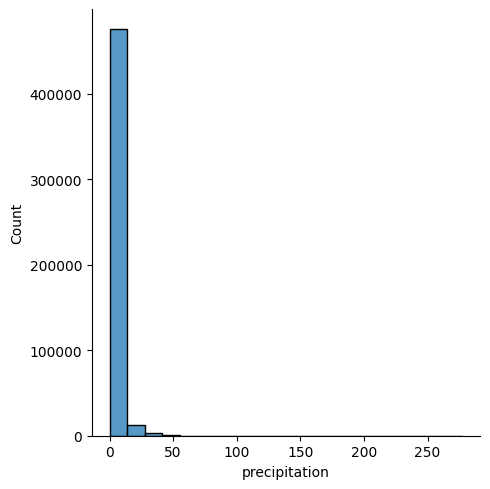

In [ ]:
sns.displot((train['precipitation']))

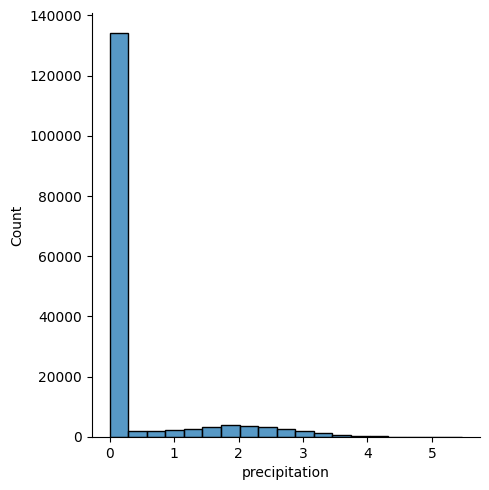

In [ ]:
sns.displot(np.log1p(test['precipitation']))

In [ ]:
train['event_t'].describe()

count    492020.000000
mean        364.500000
std         210.732865
min           0.000000
25%         182.000000
50%         364.500000
75%         547.000000
max         729.000000
Name: event_t, dtype: float64

In [ ]:
train[train['label']==1]['event_t'].describe()

count    318.000000
mean     364.367925
std       40.259331
min      296.000000
25%      328.250000
50%      365.500000
75%      396.000000
max      435.000000
Name: event_t, dtype: float64

In [ ]:
train['event_t'].describe()

count    492020.000000
mean        364.500000
std         210.732865
min           0.000000
25%         182.000000
50%         364.500000
75%         547.000000
max         729.000000
Name: event_t, dtype: float64

In [ ]:
train[(train['precipitation']==0) & (train['label']==1)]['event_t'].describe()

count    120.000000
mean     364.141667
std       40.033871
min      298.000000
25%      328.750000
50%      365.000000
75%      395.500000
max      435.000000
Name: event_t, dtype: float64

In [ ]:
train[(train['precipitation']!=0) & (train['label']==1)]['event_t'].describe()

count    198.000000
mean     364.505051
std       40.496004
min      296.000000
25%      327.500000
50%      366.000000
75%      396.000000
max      435.000000
Name: event_t, dtype: float64

In [ ]:
train['location_id'].nunique()

674

In [ ]:
from types import new_class
def apply_expanding_combinations(df, group_cols_list, target_col='Sales', shift_periods=[1], min_periods=1, stats=['mean', 'std']):
    # Loop through the group column combinations
    for group_cols in group_cols_list:
        # Generate base name for the grouping
        group_name = '_'.join(group_cols)

        for shift_period in shift_periods:
            for stat in stats:
                expanding_col_name = f'expanding_grouped_{group_name}_{target_col}_shift_{shift_period}_{stat}'

                # Apply groupby, shift, and expanding for the given statistic
                df[expanding_col_name] = df.groupby(group_cols)[target_col].transform(
                    lambda x: x.shift(shift_period).expanding(min_periods=min_periods).agg(stat)
                )

    return df

def smoothen_target(df, group_cols, target_col):
  n_std = 10
  for i_smooth in [target_col]:
      df_id_outlier = df.groupby(group_cols,as_index=False).agg({
          f'{i_smooth}': lambda x: x.mean() + n_std*x.std()
      }).rename(columns={f'{i_smooth}':f'{i_smooth}_outlier'})

      df_id_mean = df.groupby(group_cols,as_index=False).agg({
          f'{i_smooth}': 'mean'
      }).rename(columns={f'{i_smooth}':f'{i_smooth}_mean'})

      df = df.merge(df_id_outlier, on=group_cols[0], how='left')
      df = df.merge(df_id_mean, on=group_cols[0], how='left')

      df[f'{i_smooth}'] = np.where(
          df[f'{i_smooth}'] > df[f'{i_smooth}_outlier'],
          df[f'{i_smooth}_mean'],
          df[f'{i_smooth}']
      )

  return df


def create_rolling_features(data, group_cols, target_col, windows, shift_period, min_period, statistics):
    def apply_statistic(x, stat):
        rolled = x.shift(shift_period).rolling(window=window, min_periods=min_period)
        if stat == 'mean':
            return rolled.mean()
        elif stat == 'median':
            return rolled.median()
        elif stat == 'std':
            return rolled.std()
        elif stat == 'min':
            return rolled.min()
        elif stat == 'max':
            return rolled.max()
        elif stat == 'skew':
            return rolled.skew()
        elif stat == 'sum':
            return rolled.sum()
        elif stat == 'quantile':
            return rolled.quantile(0.95)

        elif stat.startswith('quantile_'):
            q = float(stat.split('_')[1])
            return rolled.quantile(q)
        else:
            raise ValueError(f"Unknown statistic: {stat}")

    for window in windows:
        for stat in statistics:
            stat_name = stat if not stat.startswith('quantile_') else f"{stat.split('_')[1]}th"
            col_name = f'rolling_previous_grouped_{target_col}_{stat_name}_{window}_{shift_period}'

            data[col_name] = data.groupby(group_cols)[target_col].transform(
                lambda x: apply_statistic(x, stat)
            )

    return data



def custom_agg(x):
    return x.max() - x.min()

def get_date_features(df):
  # Simulate year (assuming 365 days per year)
  df['year'] = (df['event_t'] // 365) + 1  # Year 1 or 2

  # Simulate month (approximate)
  df['month'] = ((df['event_t'] % 365) // 30) + 1  # 30-day months approximation

  # Simulate week of the year
  df['week_of_year'] = (df['event_t'] % 365) // 7 + 1

  # Simulate day of the month
  df['day_of_month'] = (df['event_t'] % 30) + 1  # Assuming 30-day months

  # Simulate day of the week (0 = Monday, 6 = Sunday)
  df['day_of_week'] = df['event_t'] % 7

  # Simulate quarter
  df['quarter'] = ((df['month'] - 1) // 3) + 1
  return  df




def feature_engineering(train, test):
  data = pd.concat([train, test])
  data.sort_values(by = ['location_id', 'event_t'], inplace=True)
  data['event_t'] = data['event_t'].astype(int)
  # data = smoothen_target(data, ['location_id'], 'precipitation')

  data['event_binary'] = data['event_t'].apply(lambda x: 1 if (x >= 296 and x <= 435) else 0)


  group_cols =['location_id']
  # data = apply_expanding_combinations(
  #     data,
  #     [group_cols],
  #     target_col='precipitation',
  #     shift_periods=[1],#1,3, 4, 5, 6, 7, 8, 24
  #     min_periods=1,
  #     stats=['mean']
  # )

  statistics = ['mean'] #, 'median', 'std', 'quantile_0.25', 'quantile_0.75'
  min_period = 1

  shift_period = 0
  windows = [3, 4,10,20, 25, 30,55,60, 75, 296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 2
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 3
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 4
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 5
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 6
  # windows = [ 3,4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 8
  # windows = [ 3,4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)
  # # data = get_date_features(data)

  for col in ['precipitation']:
    # data[f"grouped_location_{col}_cum"] = data.groupby('location_id')[col].cumsum().shift(1)

    # quantile = 0.95  # Define the quantile you want to calculate
    # for stat in ['mean', 'quantile']:
    #     if stat != 'quantile':
    #         data[f"location_grouped_{col}_{stat}"] = data.groupby('location_id')[col].transform(stat)
    #         data[f"diff_{col}_{stat}"] = data[col] - data[f"location_grouped_{col}_{stat}"]


    for shift in range(1,365):
      data[f'{col}_shift_{shift}'] = data.groupby('location_id')[col].shift(shift)
      data[f'{col}_next_shift_{shift}'] = data.groupby('location_id')[col].shift(-shift)




    # for window in windows:
    #   data[f'{col}_rolling_grouped_custom_{window}'] = (
    #       data.groupby('location_id')[col]
    #       .rolling(window)
    #       .apply(custom_agg)
    #       .reset_index(level=0, drop=True)  # Reset the index to align with the original DataFrame
    #   )

    for span in [7]:
        data[f'{col}_ewm_grouped_mean_{span}'] = (
            data.groupby('location_id')[col]
            .ewm(span=span, adjust=False)
            .mean()
            .reset_index(level=0, drop=True)  # Reset the index to align it with the original DataFrame
        )




  train = data[data['label'].notna()].reset_index(drop = True)
  test = data[data['label'].isna()].reset_index(drop = True)

  return train, test

new_train, new_test = feature_engineering(train_df, test_df)
display(new_train.head(), new_train.shape, new_test.head(), new_test.shape)

,event_id,precipitation,label,location_id,event_idx,event_t,flood_probability,NDVI_mean,NDVI_median,NDVI_std,...,precipitation_next_shift_360,precipitation_shift_361,precipitation_next_shift_361,precipitation_shift_362,precipitation_next_shift_362,precipitation_shift_363,precipitation_next_shift_363,precipitation_shift_364,precipitation_next_shift_364,precipitation_ewm_grouped_mean_7
0,id_05v6zjuaf300_X_0,0.00000,0.0,id_05v6zjuaf300,435,0,0.997973,0.306647,0.289123,0.300898,...,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,6.01065,0.000000
1,id_05v6zjuaf300_X_1,9.45176,0.0,id_05v6zjuaf300,435,1,0.997973,0.306647,0.289123,0.300898,...,0.00000,NaN,0.00000,NaN,0.00000,NaN,6.01065,NaN,24.95070,2.362940
2,id_05v6zjuaf300_X_2,0.00000,0.0,id_05v6zjuaf300,435,2,0.997973,0.306647,0.289123,0.300898,...,0.00000,NaN,0.00000,NaN,6.01065,NaN,24.95070,NaN,0.00000,1.772205
3,id_05v6zjuaf300_X_3,0.00000,0.0,id_05v6zjuaf300,435,3,0.997973,0.306647,0.289123,0.300898,...,0.00000,NaN,6.01065,NaN,24.95070,NaN,0.00000,NaN,0.00000,1.329154
4,id_05v6zjuaf300_X_4,0.00000,0.0,id_05v6zjuaf300,435,4,0.997973,0.306647,0.289123,0.300898,...,6.01065,NaN,24.95070,NaN,0.00000,NaN,0.00000,NaN,0.00000,0.996865


(492020, 765)

,event_id,precipitation,label,location_id,event_idx,event_t,flood_probability,NDVI_mean,NDVI_median,NDVI_std,...,precipitation_next_shift_360,precipitation_shift_361,precipitation_next_shift_361,precipitation_shift_362,precipitation_next_shift_362,precipitation_shift_363,precipitation_next_shift_363,precipitation_shift_364,precipitation_next_shift_364,precipitation_ewm_grouped_mean_7
0,id_066zz28m11mr_X_0,0.0,NaN,id_066zz28m11mr,118,0,0.013285,0.081579,0.079895,0.023026,...,0.605245,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
1,id_066zz28m11mr_X_1,0.0,NaN,id_066zz28m11mr,118,1,0.013285,0.081579,0.079895,0.023026,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
2,id_066zz28m11mr_X_2,0.0,NaN,id_066zz28m11mr,118,2,0.013285,0.081579,0.079895,0.023026,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
3,id_066zz28m11mr_X_3,0.0,NaN,id_066zz28m11mr,118,3,0.013285,0.081579,0.079895,0.023026,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
4,id_066zz28m11mr_X_4,0.0,NaN,id_066zz28m11mr,118,4,0.013285,0.081579,0.079895,0.023026,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0


(163520, 765)

<Axes: xlabel='precipitation', ylabel='Density'>

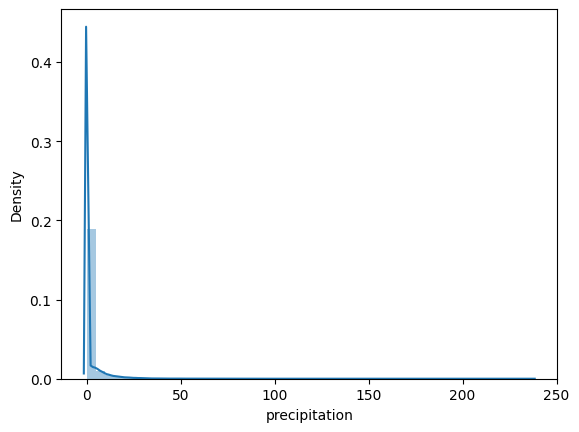

In [ ]:
sns.distplot(new_test['precipitation'])

### MODELLING
674 224

In [ ]:
new_train['label'].value_counts()

label
0.0    491702
1.0       318
Name: count, dtype: int64

In [ ]:
selected_columns = []
n_splits = 10
seed = 2024
gkf = StratifiedGroupKFold(n_splits = n_splits)

new_train['fold'] = -1
for fold, (_, val_idx) in enumerate(gkf.split(new_train, new_train['label'], groups = new_train['location_id'])):
    new_train.loc[val_idx, "fold"] = fold

new_train['fold'].value_counts()



fold
2    49640
0    49640
6    49640
1    49640
9    48910
4    48910
8    48910
7    48910
3    48910
5    48910
Name: count, dtype: int64

In [ ]:
for i in range(n_splits):
  print(new_train[new_train['fold'] == i]['label'].value_counts())
  print("-"* 100)

label
0.0    49608
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    49608
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    49608
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    48879
1.0       31
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    48878
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    48879
1.0       31
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    49608
1.0       32
Name: count, d

### MODELLING

In [ ]:
new_test.isnull().sum()

event_id                                 0
precipitation                            0
label                               163520
location_id                              0
event_idx                                0
                                     ...  
precipitation_shift_363              81312
precipitation_next_shift_363         81312
precipitation_shift_364              81536
precipitation_next_shift_364         81536
precipitation_ewm_grouped_mean_7         0
Length: 765, dtype: int64

In [ ]:

indices_cols = [
  'EVI_mean',
 'EVI_median',
 'EVI_std',
 'MNDWI_mean',
 'MNDWI_median',
 'MNDWI_std',
 'MSI_mean',
 'MSI_median',
 'MSI_std',
 'NDVI_mean',
 'NDVI_median',
 'NDVI_std',
 'NDWI_mean',
 'NDWI_median',
 'NDWI_std',
 'Slope_mean',
 'Slope_median',
 'Slope_std',
]

selected_columns =['precipitation','flood_probability','event_binary', 'event_t', ] + [col for col in new_train if 'diff' in col or 'shift' in col or 'grouped' in col ]

print(selected_columns)
target_col = 'label'


['precipitation', 'flood_probability', 'event_binary', 'event_t', 'rolling_previous_grouped_precipitation_mean_3_0', 'rolling_previous_grouped_precipitation_mean_4_0', 'rolling_previous_grouped_precipitation_mean_10_0', 'rolling_previous_grouped_precipitation_mean_20_0', 'rolling_previous_grouped_precipitation_mean_25_0', 'rolling_previous_grouped_precipitation_mean_30_0', 'rolling_previous_grouped_precipitation_mean_55_0', 'rolling_previous_grouped_precipitation_mean_60_0', 'rolling_previous_grouped_precipitation_mean_75_0', 'rolling_previous_grouped_precipitation_mean_296_0', 'precipitation_shift_1', 'precipitation_next_shift_1', 'precipitation_shift_2', 'precipitation_next_shift_2', 'precipitation_shift_3', 'precipitation_next_shift_3', 'precipitation_shift_4', 'precipitation_next_shift_4', 'precipitation_shift_5', 'precipitation_next_shift_5', 'precipitation_shift_6', 'precipitation_next_shift_6', 'precipitation_shift_7', 'precipitation_next_shift_7', 'precipitation_shift_8', 'prec

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import log_loss, roc_auc_score
from scipy.stats import hmean, gmean
best_params = {'learning_rate': 0.016226523477784777, 'num_leaves': 149, 'max_depth': 5, 'min_child_samples': 68, 'subsample': 0.9428235009861372, 'colsample_bytree': 0.6777765477699621, 'reg_alpha': 1.2477199064267164, 'reg_lambda': 2.9034162965658536, 'min_split_gain': 0.20065519236515317, 'n_estimators': 1147}
best_params_24_80 = {'learning_rate': 0.026196225260523457, 'num_leaves': 76, 'max_depth': 5, 'min_child_samples': 68, 'subsample': 0.6467307357698872, 'colsample_bytree': 0.5967342875410537, 'reg_alpha': 1.4562432955683917, 'reg_lambda': 9.217783414325323, 'min_split_gain': 0.13139751732865262, 'n_estimators': 1000}
best_params_24_20 = {'learning_rate': 0.018722351166034854, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 46, 'subsample': 0.44731979118276816, 'colsample_bytree': 0.6210976425615791, 'reg_alpha': 1.3618578798595646, 'reg_lambda': 2.202131213326094, 'min_split_gain': 0.25950073313211, 'n_estimators': 1000}
# Initialize placeholders
test_preds_list = []  # Store fold-wise test predictions
loglosses = []
oof_preds = np.zeros(len(new_train))

# K-Fold Training
for fold in range(n_splits):
    print(f"============================= TRAINING FOLD: {fold+1} ================================")

    training = new_train[new_train['fold'] != fold]
    validation = new_train[new_train['fold'] == fold]


    y_train = training[target_col]
    y_test = validation[target_col]
    X_train = training[selected_columns]
    X_test = validation[selected_columns]

    # Train the LightGBM model
    model = lgb.LGBMClassifier(**best_params,
        objective="binary",
        metric="binary_logloss",
        boosting_type="gbdt",
        verbosity=-1,
        random_state=42)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="logloss")

    # Store out-of-fold predictions
    oof_preds[validation.index] = model.predict_proba(X_test, model.best_iteration_)[:, 1]

    # Calculate logloss
    loss = log_loss(y_test, model.predict_proba(X_test, model.best_iteration_)[:, 1])
    print(f"Logloss: {loss}")
    print("*" * 100)
    loglosses.append(loss)

    # Inference on the test set
    fold_preds = model.predict_proba(new_test[selected_columns], model.best_iteration_)[:, 1]
    test_preds_list.append(fold_preds)  # Store for alternative means

    # Save fold-specific submission file
    fold_submission = new_test[['event_id']].copy()
    fold_submission['lgb_preds'] = fold_preds
    fold_filename = f'lightgbm_fold_{fold+1}.csv'
    fold_submission.to_csv(fold_filename, index=False)
    print(f"Saved fold {fold+1} predictions to '{fold_filename}'")

# Compute final scores
new_train['oof_lgb'] = oof_preds
print(f"Mean logloss: {np.mean(loglosses)}")
print(f"OOF logloss: {log_loss(new_train['label'], new_train['oof_lgb'])}")
print(f"OOF roc_auc: {roc_auc_score(new_train['label'], new_train['oof_lgb'])}")

# Convert list of fold predictions to NumPy array (shape: n_splits x n_samples)
fold_preds_array = np.array(test_preds_list)

# Compute different mean types
avg_preds_arith = fold_preds_array.mean(axis=0)  # Arithmetic mean
avg_preds_hmean = hmean(fold_preds_array, axis=0)  # Harmonic mean
avg_preds_gmean = gmean(fold_preds_array, axis=0)  # Geometric mean

# Ensure numerical stability (hmean & gmean might cause issues with zero values)
avg_preds_hmean = np.nan_to_num(avg_preds_hmean, nan=avg_preds_arith)
avg_preds_gmean = np.nan_to_num(avg_preds_gmean, nan=avg_preds_arith)

# Save different mean-based submissions
for method, preds in zip(["avg", "hmean", "gmean"], [avg_preds_arith, avg_preds_hmean, avg_preds_gmean]):
    if method == "avg":
        new_test['lgb_preds'] = avg_preds_arith

    submission = new_test[['event_id']].copy()
    submission['lgb_preds'] = preds
    submission.to_csv(f'lightgbm_{method}.csv', index=False)
    print(f"Saved {method} mean predictions to 'lightgbm_{method}.csv'")


============================= TRAINING FOLD: 1 ================================
Logloss: 0.002338497153409839
****************************************************************************************************
Saved fold 1 predictions to 'lightgbm_fold_1.csv'
============================= TRAINING FOLD: 2 ================================
Logloss: 0.0021324288551286055
****************************************************************************************************
Saved fold 2 predictions to 'lightgbm_fold_2.csv'
============================= TRAINING FOLD: 3 ================================
Logloss: 0.0024924615423261125
****************************************************************************************************
Saved fold 3 predictions to 'lightgbm_fold_3.csv'
============================= TRAINING FOLD: 4 ================================
Logloss: 0.002707702375949587
****************************************************************************************************
Save

Text(0.5, 1.0, 'catboost features importance :')

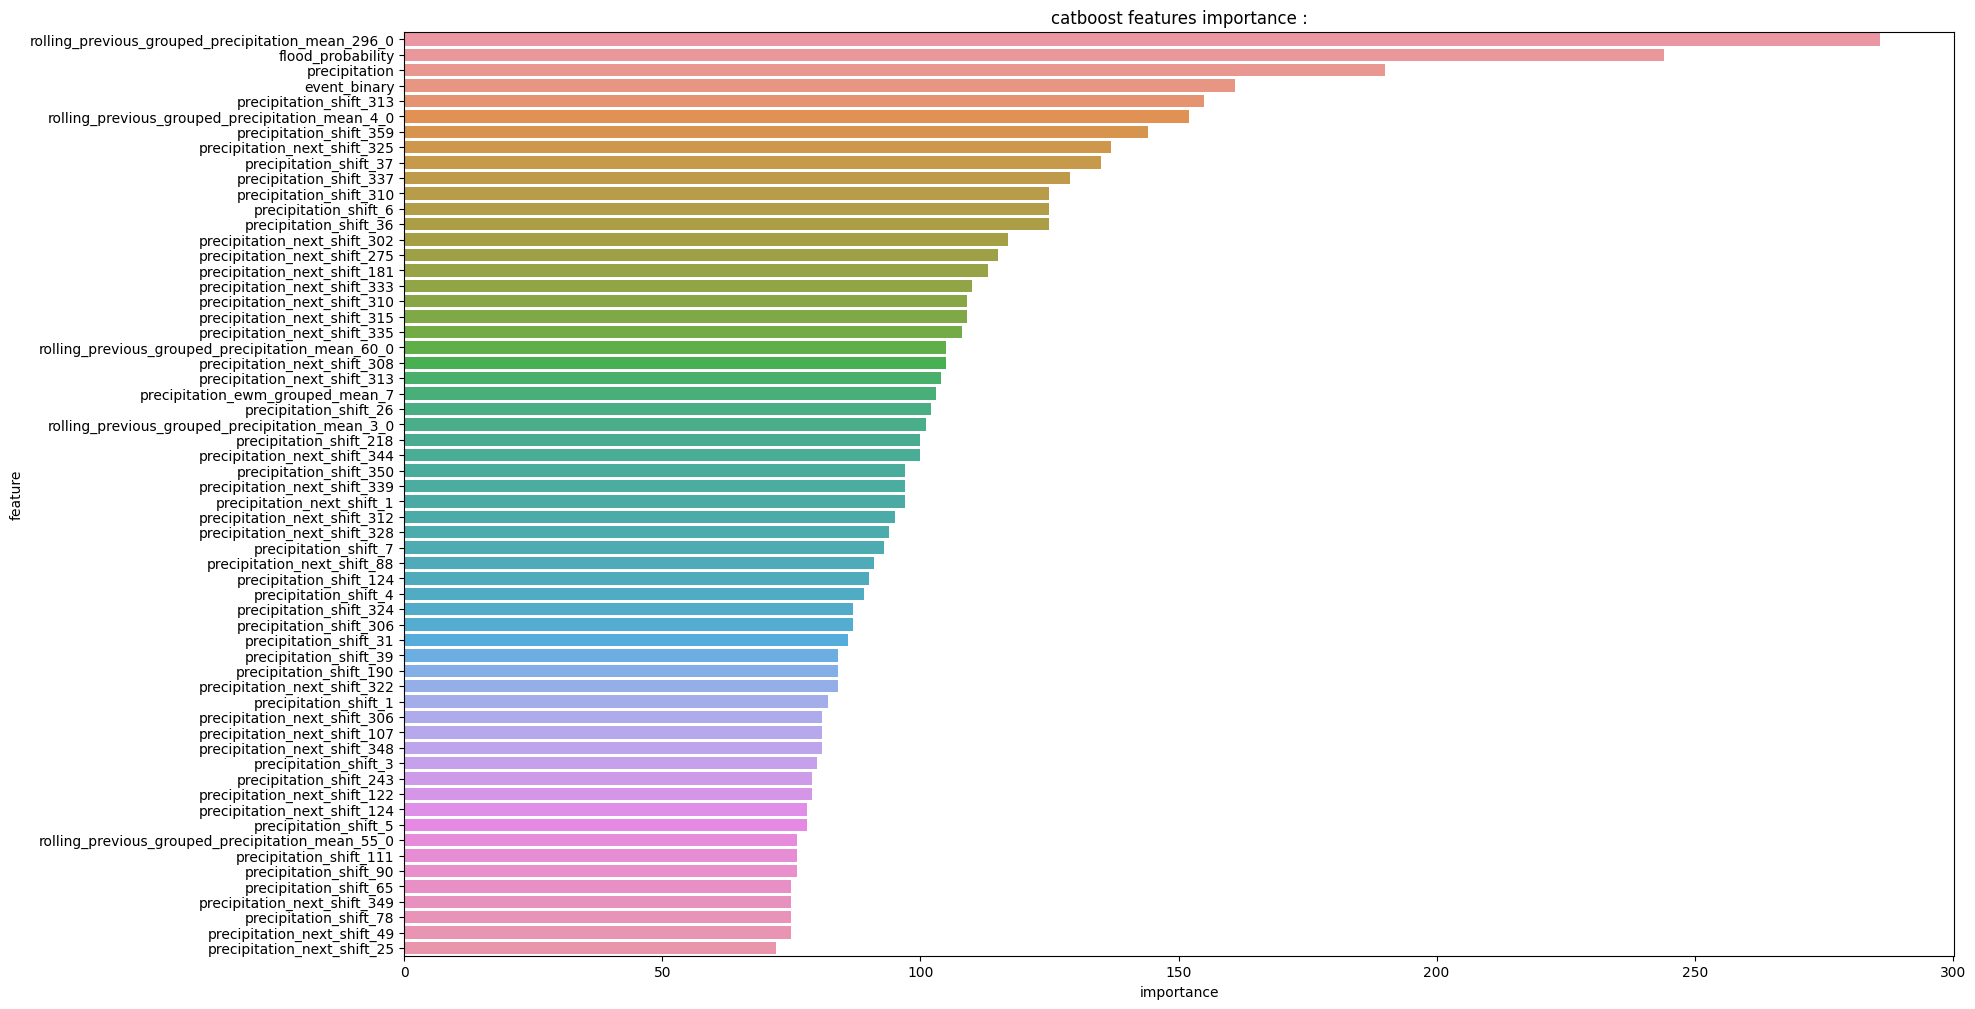

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = selected_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('catboost features importance :')

## Normalization

In [ ]:
from sklearn.metrics import log_loss

print(f"logloss before normalizing: {log_loss(new_train['label'], new_train['oof_lgb'])}")

locations_to_normalize = new_train[new_train['flood_probability'] >= 0.5]['location_id'].unique()
new_train['oof_sum_prob'] = new_train.groupby('location_id')['oof_lgb'].transform('sum')

# Avoid division by zero
epsilon = 1e-8
new_train['oof_lgb_norm'] = new_train['oof_lgb']  # Copy original values

new_train.loc[new_train['location_id'].isin(locations_to_normalize), 'oof_lgb_norm'] = (
    new_train.loc[new_train['location_id'].isin(locations_to_normalize), 'oof_lgb'] /
    (new_train.loc[new_train['location_id'].isin(locations_to_normalize), 'oof_sum_prob'] + epsilon)
)

print(f"logloss after normalizing: {log_loss(new_train['label'], new_train['oof_lgb_norm'])}")


logloss before normalizing: 0.002392372256798661
logloss after normalizing: 0.0022503198590231688


In [ ]:
new_train[['event_id', 'location_id', 'event_t', 'flood_probability','label','oof_lgb']].to_csv("lgb_train_with_oof.csv", index=False)
new_test[['event_id', 'location_id', 'event_t', 'flood_probability','label','lgb_preds']].to_csv("lgb_test_with_oof.csv", index=False)

### Normalize The Predictions based on the flood probability

In [ ]:
locations_to_normalize = new_test[new_test['flood_probability'] >= 0.7]['location_id'].unique()
new_test['oof_sum_prob'] = new_test.groupby('location_id')['lgb_preds'].transform('sum')

# Avoid division by zero
epsilon = 1e-8
new_test['lgb_preds_norm'] = new_test['lgb_preds']  # Copy original values

new_test.loc[new_test['location_id'].isin(locations_to_normalize), 'lgb_preds_norm'] = (
    new_test.loc[new_test['location_id'].isin(locations_to_normalize), 'lgb_preds'] /
    (new_test.loc[new_test['location_id'].isin(locations_to_normalize), 'oof_sum_prob'] + epsilon)
)

new_test.head()

,event_id,precipitation,label,location_id,event_idx,event_t,flood_probability,NDVI_mean,NDVI_median,NDVI_std,...,precipitation_shift_362,precipitation_next_shift_362,precipitation_shift_363,precipitation_next_shift_363,precipitation_shift_364,precipitation_next_shift_364,precipitation_ewm_grouped_mean_7,lgb_preds,oof_sum_prob,lgb_preds_norm
0,id_066zz28m11mr_X_0,0.0,NaN,id_066zz28m11mr,118,0,0.013285,0.081579,0.079895,0.023026,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,5.844456e-08,0.015846,5.844456e-08
1,id_066zz28m11mr_X_1,0.0,NaN,id_066zz28m11mr,118,1,0.013285,0.081579,0.079895,0.023026,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,5.884309e-08,0.015846,5.884309e-08
2,id_066zz28m11mr_X_2,0.0,NaN,id_066zz28m11mr,118,2,0.013285,0.081579,0.079895,0.023026,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,7.174250e-08,0.015846,7.174250e-08
3,id_066zz28m11mr_X_3,0.0,NaN,id_066zz28m11mr,118,3,0.013285,0.081579,0.079895,0.023026,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,7.837302e-08,0.015846,7.837302e-08
4,id_066zz28m11mr_X_4,0.0,NaN,id_066zz28m11mr,118,4,0.013285,0.081579,0.079895,0.023026,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,5.686352e-08,0.015846,5.686352e-08


In [ ]:

mod_sub = new_test[['event_id', 'lgb_preds_norm']]
mod_sub.head()

,event_id,lgb_preds_norm
0,id_066zz28m11mr_X_0,5.844456e-08
1,id_066zz28m11mr_X_1,5.884309e-08
2,id_066zz28m11mr_X_2,7.174250e-08
3,id_066zz28m11mr_X_3,7.837302e-08
4,id_066zz28m11mr_X_4,5.686352e-08


In [ ]:
mod_sub.to_csv("lgb_best_mod.csv", index = False)

In [ ]:
mod_sub.describe()

,lgb_preds_norm
count,1.635200e+05
mean,6.488648e-04
std,1.337905e-02
min,3.988643e-08
25%,4.150010e-07
50%,1.488486e-06
75%,1.093373e-05
max,8.753424e-01
